# 02 — Final Analysis and Paper Figures

Unisce i risultati da GTZAN (WITH_AUG/NO_AUG) e FMA per generare tabelle e figure finali.


## Panoramica del Notebook

Questo notebook aggrega i risultati dei vari work package e produce le figure finali per la consegna. Struttura:

- WP1 — Ablation: confronto con/ senza augmentation
- WP2 — Efficienza: Params, FLOPs, Latenza vs Accuratezza
- WP3 — Cross-dataset (FMA Small): riepilogo
- WP4 — K-Fold su GTZAN: media ± std e per-fold
- Leaderboard e selezione del modello “champion”
- Deep-dive del champion: confusion matrix, classification report, t-SNE
- Confronto finale (bar chart)

Note esecuzione:

- Il codice è in inglese; le spiegazioni sono in italiano.
- Il deep-dive usa CPU per evitare OOM e può riusare i risultati se già presenti (caching).


In [65]:
# Load summaries and configure paths (robust project root detection)
import os, sys, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from IPython.display import display

# Robustly locate PROJECT_ROOT by ascending until 'reports' directory is found
cwd = Path(os.getcwd()).resolve()
root = cwd
while root != root.parent and not (root/'reports').exists():
    root = root.parent
PROJECT_ROOT = root if (root/'reports').exists() else cwd.parent  # fallback one level up

# Paths
REPORTS = PROJECT_ROOT/'reports'
MODELS_PATH = PROJECT_ROOT/'models'
PROCESSED_GTZAN = PROJECT_ROOT/'data'/'processed'
PROCESSED_FMA = PROJECT_ROOT/'data'/'processed_fma'

# Styling
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.dpi'] = 100

print('Project root:', PROJECT_ROOT)
print('Reports directory:', REPORTS)

# Summary files
GTZAN_WITH = REPORTS/'training_summary_WITH_AUG.csv'
GTZAN_NO = REPORTS/'training_summary_NO_AUG.csv'
FMA_SUM = REPORTS/'training_summary_FMA.csv'
CV_SUM = REPORTS/'kfold_cv_unet_gtzan.csv'
CV_FOLDS = REPORTS/'kfold_cv_unet_gtzan_folds.csv'

# Load available summaries
dfs = {}
if GTZAN_WITH.exists(): dfs['WITH_AUG'] = pd.read_csv(GTZAN_WITH)
if GTZAN_NO.exists(): dfs['NO_AUG'] = pd.read_csv(GTZAN_NO)
if FMA_SUM.exists(): dfs['FMA'] = pd.read_csv(FMA_SUM)
if CV_SUM.exists(): dfs['CV_SUM'] = pd.read_csv(CV_SUM)
if CV_FOLDS.exists(): dfs['CV_FOLDS'] = pd.read_csv(CV_FOLDS)

print('Loaded summaries:', ', '.join(dfs.keys()) if dfs else 'none found')

Project root: /home/alepot55/Desktop/projects/naml_project
Reports directory: /home/alepot55/Desktop/projects/naml_project/reports
Loaded summaries: WITH_AUG, NO_AUG, FMA, CV_SUM, CV_FOLDS


## Setup and Data Discovery

In questa sezione configuriamo i percorsi, rileviamo automaticamente la root del progetto e carichiamo i riepiloghi disponibili. Tutto il codice, i commenti e le stampe sono in inglese per coerenza nella consegna.


In [66]:
# WP1: Accuracy with vs without augmentation
if 'WITH_AUG' in dfs and 'NO_AUG' in dfs:
    merged = pd.merge(dfs['WITH_AUG'][['Model','Test_Accuracy']],
                      dfs['NO_AUG'][['Model','Test_Accuracy']], on='Model',
                      suffixes=('_WITH_AUG','_NO_AUG'))
    if not len(merged):
        print('WP1: No overlapping models between WITH_AUG and NO_AUG summaries.')
    else:
        merged['Gain_pp'] = 100*(merged['Test_Accuracy_WITH_AUG']-merged['Test_Accuracy_NO_AUG'])
        merged = merged.sort_values('Gain_pp', ascending=False)
        display(merged)
        out_csv = REPORTS/'wp1_ablation_with_vs_without_aug.csv'
        merged.to_csv(out_csv, index=False)
        print('Saved:', out_csv)
else:
    print('WP1: Missing results. Please run the GTZAN tournament with and without augmentation.')

,Model,Test_Accuracy_WITH_AUG,Test_Accuracy_NO_AUG,Gain_pp
2,UNet_Audio_Classifier,0.823,0.8180,0.500000
1,ResSE_AudioCNN,0.798,0.7990,-0.100005
0,Efficient_VGG,0.752,0.7535,-0.150001


Saved: /home/alepot55/Desktop/projects/naml_project/reports/wp1_ablation_with_vs_without_aug.csv


## WP1 — Ablation on SpecAugment

Confrontiamo l'accuratezza test con e senza data augmentation (SpecAugment). Ci aspettiamo un piccolo guadagno in media; differenze troppo grandi possono indicare variabilità dovuta a random seed o split.


,Model,Params,Approx_FLOPs,Latency_ms,Test_Accuracy
2,UNet_Audio_Classifier,1176170,0.0,23.066792,0.823
1,ResSE_AudioCNN,1232770,0.0,26.752510,0.798
0,Efficient_VGG,34488,0.0,14.771867,0.752


Saved: /home/alepot55/Desktop/projects/naml_project/reports/wp2_efficiency_metrics.csv


/tmp/ipykernel_47751/2496086713.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1].set_xscale('log')


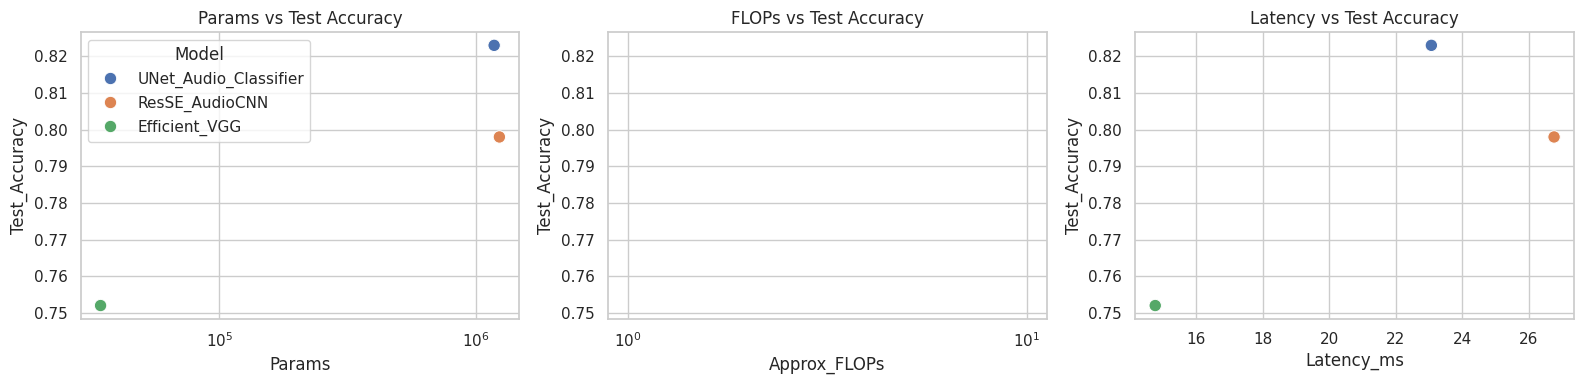

In [67]:
# WP2: Efficiency metrics table and plots
if 'WITH_AUG' in dfs:
    cols = ['Model','Params','Approx_FLOPs','Latency_ms','Test_Accuracy']
    if all(c in dfs['WITH_AUG'].columns for c in cols):
        eff = dfs['WITH_AUG'][cols].sort_values('Test_Accuracy', ascending=False)
        display(eff)
        out_csv = REPORTS/'wp2_efficiency_metrics.csv'
        eff.to_csv(out_csv, index=False)
        print('Saved:', out_csv)
        # Plots
        sns.set_theme(style='whitegrid')
        fig, axes = plt.subplots(1,3, figsize=(16,4))
        sns.scatterplot(ax=axes[0], data=eff, x='Params', y='Test_Accuracy', hue='Model', s=80)
        axes[0].set_title('Params vs Test Accuracy')
        axes[0].set_xscale('log')
        sns.scatterplot(ax=axes[1], data=eff, x='Approx_FLOPs', y='Test_Accuracy', hue='Model', s=80, legend=False)
        axes[1].set_title('FLOPs vs Test Accuracy')
        axes[1].set_xscale('log')
        sns.scatterplot(ax=axes[2], data=eff, x='Latency_ms', y='Test_Accuracy', hue='Model', s=80, legend=False)
        axes[2].set_title('Latency vs Test Accuracy')
        plt.tight_layout()
        plt.show()
    else:
        print('WP2: Missing columns in WITH_AUG results. Re-run training with updated notebook to compute efficiency metrics.')
else:
    print('WP2: WITH_AUG results not found.')

## WP2 — Computational Efficiency

Confrontiamo parametri, FLOPs approssimati e latenza (batch=1) contro l'accuratezza. I valori dipendono dall'hardware; qui servono per confronto relativo tra architetture.


In [68]:
# WP4: K-Fold CV results for UNet on GTZAN
if 'CV_SUM' in dfs:
    display(dfs['CV_SUM'])
    if 'CV_FOLDS' in dfs:
        print('Per-fold results:')
        display(dfs['CV_FOLDS'])
else:
    print('WP4: No K-Fold results found. Please run 01c_KFold_CV_UNet_GTZAN.ipynb')

,Model,Dataset,K,ValAcc_Mean,ValAcc_Std
0,UNet_Audio_Classifier,GTZAN,5,0.904375,0.006835


Per-fold results:


,Fold,Val_Accuracy,Time_s
0,1,0.900625,152.923059
1,2,0.894375,145.697510
2,3,0.914375,147.913864
3,4,0.903750,174.203336
4,5,0.908750,122.072955


## WP4 — 5-Fold Cross-Validation on GTZAN (UNet)

Mostriamo la media e la deviazione standard dell'accuratezza di validazione sui 5 fold, più i risultati per-fold per verificare stabilità.


In [69]:
# WP3: FMA Small UNet results (if available)
if 'FMA' in dfs:
    display(dfs['FMA'])
else:
    print('Please run FMA notebooks to generate the summary (reports/training_summary_FMA.csv).')

,Model,Dataset,Best_Val_Accuracy,Test_Accuracy,Epochs_Run
0,UNet_Audio_Classifier,FMA_SMALL,0.666667,0.94,24


## WP3 — Cross-Dataset Generalization (FMA Small)

Verifichiamo la capacità del modello UNet di generalizzare su un dataset diverso (FMA Small) mantenendo impostazioni audio coerenti.


In [70]:
# Identify champion model across available summaries (prefer Test_Accuracy)
champion_df, source, sort_col = None, None, None
for key in ['WITH_AUG', 'NO_AUG', 'FMA']:
    if key in dfs:
        cols = dfs[key].columns
        if ('Test_Accuracy' in cols) or ('Best_Val_Accuracy' in cols):
            champion_df = dfs[key].copy()
            source = key
            sort_col = 'Test_Accuracy' if 'Test_Accuracy' in cols else 'Best_Val_Accuracy'
            break

if champion_df is None:
    raise RuntimeError('No summary found with expected columns. Please run the training notebooks.')

leaderboard = champion_df.sort_values(sort_col, ascending=False).reset_index(drop=True)
display(leaderboard)

champion_row = leaderboard.iloc[0]
champion_model_name = champion_row['Model']
champion_test_accuracy = champion_row['Test_Accuracy'] if 'Test_Accuracy' in champion_row.index else np.nan

print(f"Champion: {champion_model_name} (source: {source})")
if not np.isnan(champion_test_accuracy):
    print(f"Test Accuracy: {champion_test_accuracy:.4f}")

,Model,Tag,Best_Val_Accuracy,Test_Accuracy,Epochs_Run,Params,Approx_FLOPs,Latency_ms
0,UNet_Audio_Classifier,WITH_AUG,0.8525,0.823,73,1176170,0.0,23.066792
1,ResSE_AudioCNN,WITH_AUG,0.8155,0.798,55,1232770,0.0,26.752510
2,Efficient_VGG,WITH_AUG,0.7530,0.752,96,34488,0.0,14.771867


Champion: UNet_Audio_Classifier (source: WITH_AUG)
Test Accuracy: 0.8230


## Leaderboard and Champion Selection

Selezioniamo il miglior modello disponibile privilegiando GTZAN (WITH_AUG → NO_AUG) e poi FMA. L'ordinamento avviene su `Test_Accuracy` se presente, altrimenti su `Best_Val_Accuracy`.


Model loaded: UNet_Audio_Classifier_best_WITH_AUG.keras


Model: "UNet_Audio_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_conv1 (Conv2D)             │ (None, 128, 128, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_bn1 (BatchNormalization)   │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_prelu1 (PReLU)             │ (None, 128, 128, 32)   │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_conv2 (Conv2D)             │ (None, 128, 128, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_bn2 (BatchNormalization)   │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_prelu2 (PReLU)             │ (None, 128, 128, 32)   │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1_pool (MaxPooling2D)        │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_conv1 (Conv2D)             │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_bn1 (BatchNormalization)   │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_prelu1 (PReLU)             │ (None, 64, 64, 64)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_conv2 (Conv2D)             │ (None, 64, 64, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_bn2 (BatchNormalization)   │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_prelu2 (PReLU)             │ (None, 64, 64, 64)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2_pool (MaxPooling2D)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_conv1 (Conv2D)             │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_bn1 (BatchNormalization)   │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_prelu1 (PReLU)             │ (None, 32, 32, 128)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_conv2 (Conv2D)             │ (None, 32, 32, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_bn2 (BatchNormalization)   │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_prelu2 (PReLU)             │ (None, 32, 32, 128)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc3_pool (MaxPooling2D)        │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bneck_conv1 (Conv2D)            │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bneck_bn1 (BatchNormalization)  │ (None, 16, 16, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bneck_prelu1 (PReLU)            │ (None, 16, 16, 256)    │           25

 Total params: 3,530,432 (13.47 MB)

 Trainable params: 1,176,170 (4.49 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2,352,342 (8.97 MB)

Saved: /home/alepot55/Desktop/projects/naml_project/reports/confusion_matrix_UNet_Audio_Classifier_WITH_AUG.png


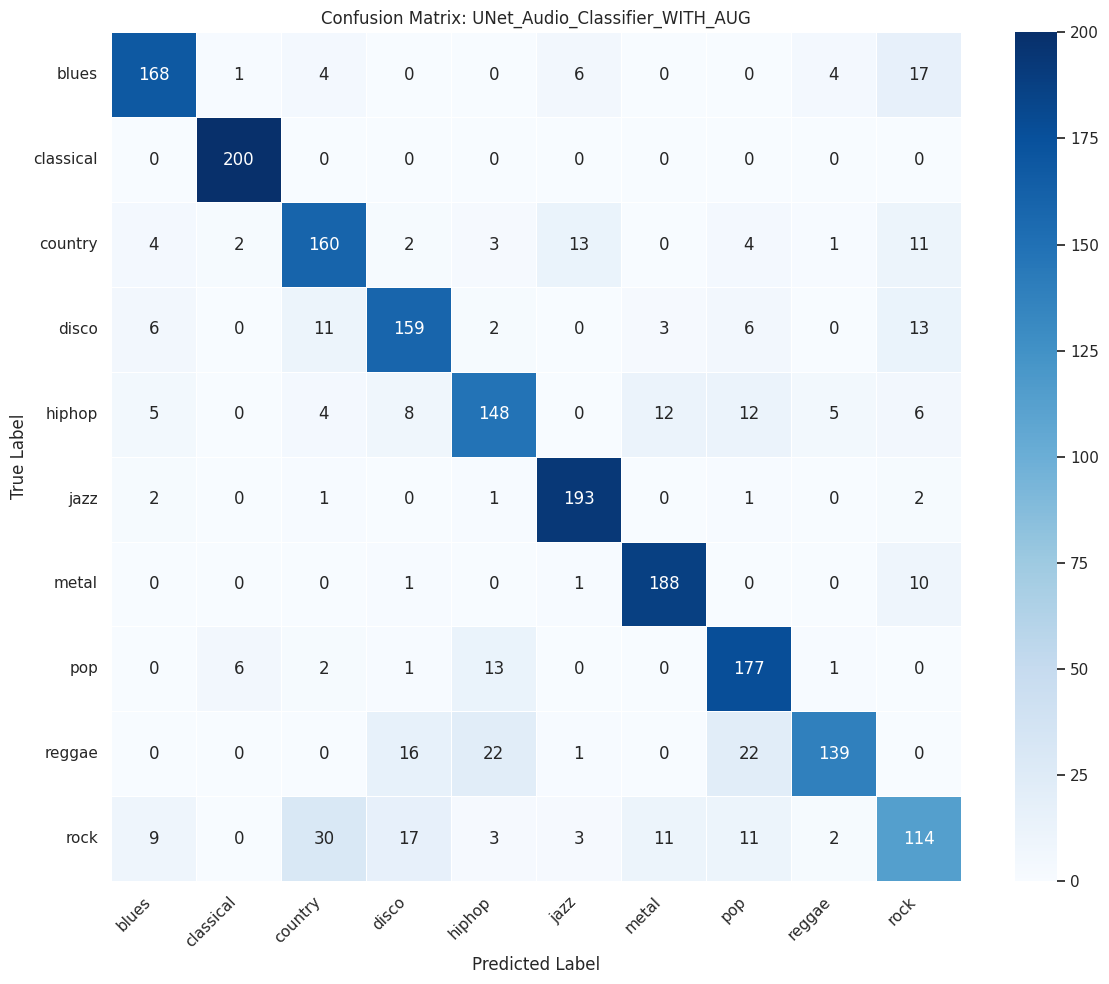

              precision    recall  f1-score   support

       blues       0.87      0.84      0.85       200
   classical       0.96      1.00      0.98       200
     country       0.75      0.80      0.78       200
       disco       0.78      0.80      0.79       200
      hiphop       0.77      0.74      0.76       200
        jazz       0.89      0.96      0.93       200
       metal       0.88      0.94      0.91       200
         pop       0.76      0.89      0.82       200
      reggae       0.91      0.69      0.79       200
        rock       0.66      0.57      0.61       200

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000

Saved: /home/alepot55/Desktop/projects/naml_project/reports/classification_report_UNet_Audio_Classifier_WITH_AUG.txt
Saved: /home/alepot55/Desktop/projects/naml_project/reports/tsne_visualization_UNet_Audio_Classifier_WITH_AUG.png
Saved: /ho

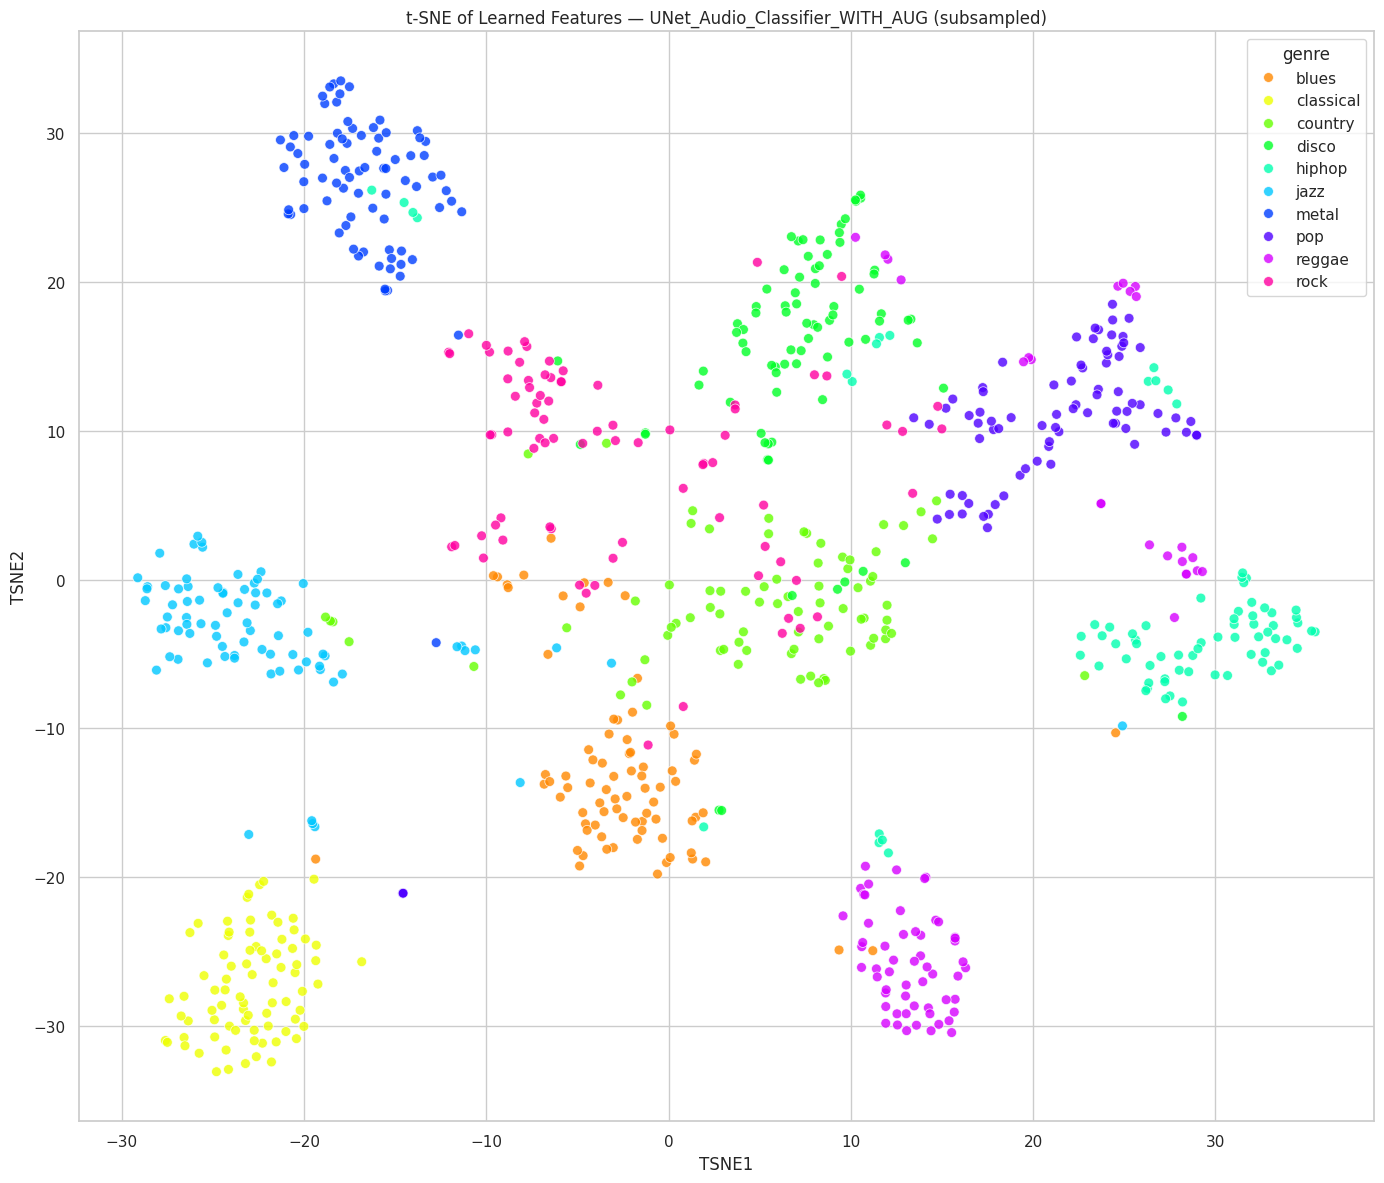

In [74]:
# Champion deep-dive: load model and run confusion matrix + classification report + t-SNE (OOM-safe)
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

import keras
from keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

# Optional: enable TF memory growth if a GPU is present (best-effort)
try:
    import tensorflow as tf
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass
except Exception:
    tf = None

# Small, safe batch size for inference
BS = int(os.environ.get('INFER_BATCH_SIZE', '8'))
# Caching toggles
USE_CACHE = os.environ.get('FINAL_ANALYSIS_USE_CACHE', '1') == '1'
NORMALIZE_CM = os.environ.get('NORMALIZE_CM', '0') == '1'  # normalize confusion matrix by true class

# Reuse preloaded test data/encoder if available; otherwise load from disk based on `source`
if not all(name in globals() for name in ['X_test', 'y_test', 'label_encoder']):
    if source in ['WITH_AUG','NO_AUG']:
        X_test_path = PROCESSED_GTZAN/'X_test.npy'
        y_test_path = PROCESSED_GTZAN/'y_test.npy'
        le_path = PROCESSED_GTZAN/'label_encoder.pkl'
    else:
        X_test_path = PROCESSED_FMA/'X_test.npy'
        y_test_path = PROCESSED_FMA/'y_test.npy'
        le_path = PROCESSED_FMA/'label_encoder.pkl'

    if not X_test_path.exists():
        raise RuntimeError(f"Test set not found: {X_test_path}. Run the preprocessing notebook.")
    X_test = np.load(X_test_path)
    y_test = np.load(y_test_path)
    with open(le_path, 'rb') as f:
        label_encoder = pickle.load(f)

# Ensure dtype/contiguity for safer device copies
if X_test.dtype != np.float32:
    X_test = X_test.astype(np.float32, copy=False)
X_test = np.ascontiguousarray(X_test)

class_labels = np.array(label_encoder.classes_)
n_classes = len(class_labels)

# Map y_test to integer classes [0..n_classes-1] if needed
if np.issubdtype(y_test.dtype, np.integer):
    y_true = y_test
else:
    # Try to inverse/transform if strings or objects
    try:
        y_true = label_encoder.transform(y_test)
    except Exception:
        # Fallback: attempt cast to int
        y_true = y_test.astype(np.int64)
assert y_true.min() >= 0 and y_true.max() < n_classes, "y_true must be in [0, n_classes). Label encoder mismatch?"

# Resolve model path robustly (reuse precomputed if valid)
def resolve_model_path(models_dir: Path, model_name: str, source_tag: str | None, row: pd.Series):
    # 1) CSV-provided path columns
    for col in ['Model_Path','Weights_Path','ModelFile','WeightsFile','Best_Model_Path','BestModelPath']:
        if col in row.index:
            val = row[col]
            if isinstance(val, str) and val.strip():
                p = Path(val)
                if not p.is_absolute():
                    p = models_dir / val
                if p.exists():
                    print(f"Using model path from CSV column '{col}':", p)
                    return p

    # 2) Try dataset/source-suffixed patterns first
    patterns = []
    if source_tag:
        patterns += [
            f"{model_name}_{source_tag}_best.keras",
            f"{model_name}_{source_tag}*best*.keras",
            f"{model_name}_{source_tag}*.keras",
            f"{model_name}_{source_tag}_best.h5",
            f"{model_name}_{source_tag}*best*.h5",
            f"{model_name}_{source_tag}*.h5",
        ]
    # 3) Generic patterns
    patterns += [
        f"{model_name}_best.keras",
        f"{model_name}*best*.keras",
        f"{model_name}*.keras",
        f"{model_name}_best.h5",
        f"{model_name}*best*.h5",
        f"{model_name}*.h5",
    ]

    matches = []
    for pat in patterns:
        matches.extend(models_dir.glob(pat))

    if matches:
        def score(p: Path):
            s = 0
            name = p.name.lower()
            # Prefer files that explicitly match the dataset/source
            if source_tag and source_tag.lower() in name: s += 50
            # Penalize mismatched dataset tags
            if source_tag in ['WITH_AUG','NO_AUG'] and 'fma' in name: s -= 100
            if source_tag == 'FMA' and ('with_aug' in name or 'no_aug' in name): s -= 100
            if 'best' in name: s += 10
            if p.suffix == '.keras': s += 5
            try:
                s += int(p.stat().st_mtime) // 1000
            except Exception:
                pass
            return s
        best = sorted(matches, key=score, reverse=True)[0]
        print('Resolved model from patterns:', best)
        return best

    avail = list(models_dir.glob('*.keras')) + list(models_dir.glob('*.h5'))
    if avail:
        print('Available in models/:')
        for p in sorted(avail):
            print(' -', p.name)
    return None

# If an old global model_path exists but mismatches current source, discard it to force re-resolve
if 'model_path' in globals():
    try:
        name = Path(model_path).name.lower()
        if (source in ['WITH_AUG','NO_AUG'] and 'fma' in name) or (source == 'FMA' and ('with_aug' in name or 'no_aug' in name)):
            model_path = None
    except Exception:
        model_path = None

if 'model_path' not in globals() or model_path is None or not Path(model_path).exists():
    model_path = resolve_model_path(MODELS_PATH, champion_model_name, source, champion_row)
if model_path is None or not Path(model_path).exists():
    raise RuntimeError(f"Champion model not found with base name '{champion_model_name}'. Check files in {MODELS_PATH} or update the CSV with a path.")

# Clear any previous TF state and load model on CPU to avoid GPU variable placement
if 'tf' in globals() and tf is not None:
    try:
        tf.keras.backend.clear_session()
    except Exception:
        pass

if tf is not None:
    with tf.device('/CPU:0'):
        model = keras.models.load_model(model_path, custom_objects={'PReLU': layers.PReLU})
else:
    model = keras.models.load_model(model_path, custom_objects={'PReLU': layers.PReLU})

print('Model loaded:', Path(model_path).name)
try:
    model.summary()
except Exception:
    pass

# Predictions (force CPU to avoid GPU transfer/OOM)
def predict_cpu_safe(model_obj, X, bs):
    if tf is None:
        return model_obj.predict(X, batch_size=bs, verbose=0)
    try:
        with tf.device('/CPU:0'):
            return model_obj.predict(X, batch_size=bs, verbose=0)
    except Exception:
        # last resort, bs=1
        with tf.device('/CPU:0'):
            return model_obj.predict(X, batch_size=1, verbose=0)

# Disambiguated artifact name includes source tag
artifact_tag = f"{champion_model_name}_{source}"
cm_fig_path = REPORTS / f'confusion_matrix_{artifact_tag}.png'
cmn_fig_path = REPORTS / f'confusion_matrix_normalized_{artifact_tag}.png'
cr_path = REPORTS / f'classification_report_{artifact_tag}.txt'
tsne_path = REPORTS / f'tsne_visualization_{artifact_tag}.png'

need_predict = True
if USE_CACHE and cm_fig_path.exists() and cr_path.exists() and tsne_path.exists():
    print('Cache hit: existing analysis artifacts found. Set FINAL_ANALYSIS_USE_CACHE=0 to recompute.')
    need_predict = False

if need_predict:
    y_pred_probs = predict_cpu_safe(model, X_test, BS)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
    plt.title(f'Confusion Matrix: {artifact_tag}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(cm_fig_path, dpi=300, bbox_inches='tight')
    print('Saved:', cm_fig_path)
    plt.show()

    # Normalized CM (optional, per-row normalization)
    if NORMALIZE_CM:
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_norm = cm.astype(np.float32) / np.clip(cm.sum(axis=1, keepdims=True), 1e-6, None)
        cmn_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)
        plt.figure(figsize=(12,10))
        sns.heatmap(cmn_df, annot=True, fmt='.2f', cmap='Blues', linewidths=.5, vmin=0, vmax=1)
        plt.title(f'Confusion Matrix (normalized): {artifact_tag}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(cmn_fig_path, dpi=300, bbox_inches='tight')
        print('Saved:', cmn_fig_path)
        plt.show()

    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0)
    print(report)
    with open(cr_path, 'w') as f:
        f.write(report)
    print('Saved:', cr_path)

    # t-SNE of learned features — use GlobalAveragePooling2D output (compact) and subsample to avoid OOM)
    try:
        gap_layer = next(l for l in reversed(model.layers) if isinstance(l, layers.GlobalAveragePooling2D))
        # Use GAP OUTPUT (1D) instead of its input (HxWxC) to drastically reduce memory
        if tf is not None:
            with tf.device('/CPU:0'):
                feature_extractor = models.Model(inputs=model.input, outputs=gap_layer.output)
        else:
            feature_extractor = models.Model(inputs=model.input, outputs=gap_layer.output)
    except StopIteration:
        raise RuntimeError('GlobalAveragePooling2D layer not found in the model.')

    # Balanced subsample for t-SNE
    def balanced_subsample_indices(y, max_total=800, seed=42):
        rng = np.random.default_rng(seed)
        classes = np.unique(y)
        per_class = max(1, max_total // len(classes))
        idxs = []
        for c in classes:
            c_idx = np.where(y == c)[0]
            if len(c_idx) > per_class:
                c_idx = rng.choice(c_idx, size=per_class, replace=False)
            idxs.extend(c_idx.tolist())
        return np.array(idxs, dtype=int)

    sel_idx = balanced_subsample_indices(y_true, max_total=int(os.environ.get('TSNE_MAX_SAMPLES', '800')))
    X_sel = X_test[sel_idx]
    y_sel = y_true[sel_idx]

    # Free some memory before feature extraction
    try:
        gc.collect()
    except Exception:
        pass

    # Extract features on CPU to avoid GPU OOM
    def extract_features(model_fn, X, batch_size):
        if tf is None:
            return model_fn.predict(X, batch_size=batch_size, verbose=0)
        try:
            with tf.device('/CPU:0'):
                return model_fn.predict(X, batch_size=batch_size, verbose=0)
        except Exception:
            return model_fn.predict(X, batch_size=max(1, batch_size//2), verbose=0)

    features = extract_features(feature_extractor, X_sel, BS)
    if features.ndim > 2:
        features = features.reshape(features.shape[0], -1)

    # Perplexity must be < n_samples; keep within [5, 30]
    n_samples = features.shape[0]
    perp = max(5, min(30, n_samples - 1))
    # scikit-learn compatibility: try n_iter, fallback to max_iter
    try:
        tsne = TSNE(n_components=2, perplexity=perp, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
    except TypeError:
        tsne = TSNE(n_components=2, perplexity=perp, max_iter=1000, random_state=42, init='pca', learning_rate='auto')

    tsne_feats = tsne.fit_transform(features.astype(np.float32))
    tsne_df = pd.DataFrame(tsne_feats, columns=['TSNE1','TSNE2'])
    tsne_df['genre'] = label_encoder.inverse_transform(y_sel)
    plt.figure(figsize=(14,12))
    sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='genre',
                    palette=sns.color_palette('hsv', n_colors=n_classes), alpha=0.8, s=50)
    plt.title(f't-SNE of Learned Features — {artifact_tag} (subsampled)')
    plt.tight_layout()
    plt.savefig(tsne_path, dpi=300, bbox_inches='tight')
    print('Saved:', tsne_path)
    plt.show()

## Champion Deep-Dive (Confusion Matrix, Report, t-SNE)

- Carichiamo il modello su CPU per evitare OOM o mismatch GPU/CPU.
- Sanity-check: ordiniamo le etichette della CM secondo il `label_encoder`.
- t-SNE su features di GlobalAveragePooling2D con sotto-campionamento bilanciato.
- Caching: se le figure e il report esistono già, possiamo saltare il ricalcolo (toggle).


/tmp/ipykernel_47751/515677652.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y='Model', data=df_sorted, palette='viridis', orient='h')


Saved: /home/alepot55/Desktop/projects/naml_project/reports/comparative_performance_barchart_WITH_AUG.png


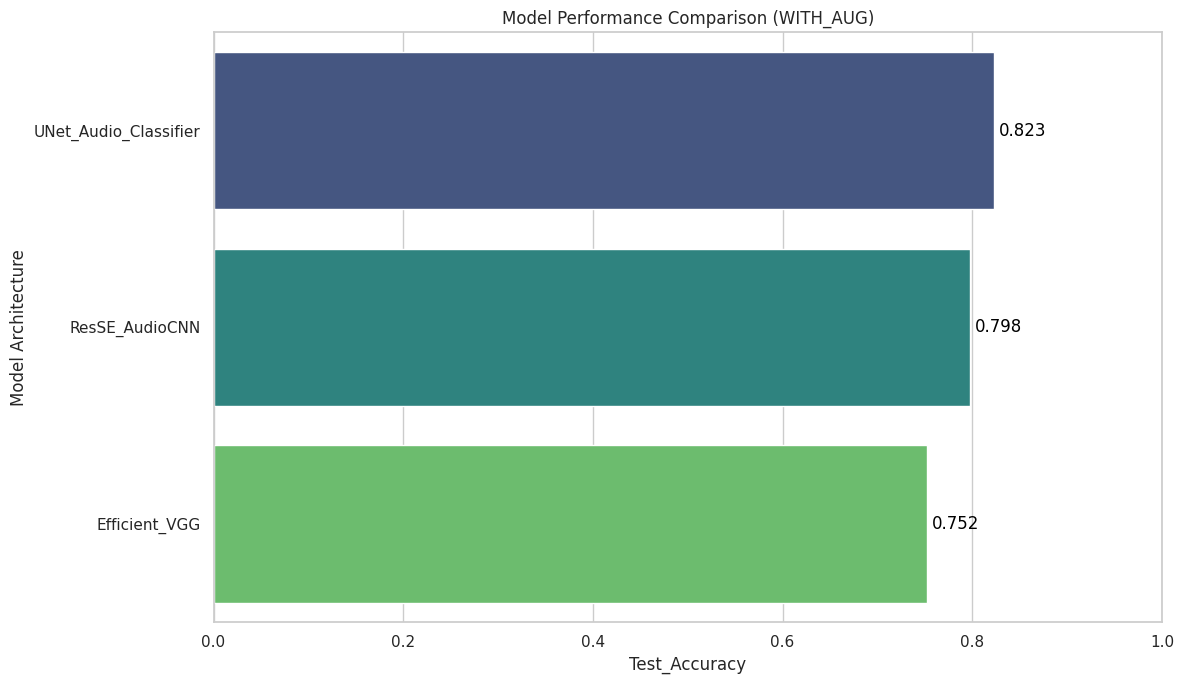

In [ ]:
# Comparative performance bar chart for the selected summary
df_to_plot = leaderboard.copy()
metric = 'Test_Accuracy' if 'Test_Accuracy' in df_to_plot.columns else sort_col
df_sorted = df_to_plot.sort_values(metric, ascending=False)

if not metric:
    raise RuntimeError(f"Expected metric '{metric}' not found in the summary. Check the loaded data.")

plt.figure(figsize=(12,7))
ax = sns.barplot(x=metric, y='Model', data=df_sorted, palette='viridis', orient='h')
for i, row in df_sorted.reset_index(drop=True).iterrows():
    ax.text(row[metric] + (0.005 if metric.endswith('Accuracy') else 0.0), i, f"{row[metric]:.3f}", color='black', ha='left', va='center')
plt.title(f'Model Performance Comparison ({source})')
plt.xlabel(metric)
plt.ylabel('Model Architecture')
if metric.endswith('Accuracy'):
    plt.xlim(0, 1.0)
plt.tight_layout()
fig_path = REPORTS/f'comparative_performance_barchart_{source}.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print('Saved:', fig_path)
plt.show()